### Potrzebne importy, wstępna konfiguracja

In [36]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import Counter

from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [37]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [38]:
rng = np.random.default_rng(73512)

### Przygotowanie danych (wraz z paddingiem)

In [39]:
train_data = pd.read_pickle('train.pkl')
test_data = pd.read_pickle('test_no_target.pkl')

In [41]:
all_elements = []
for i in train_data:
    for j in i[0]:
        all_elements.append(j)
elements_count = Counter(all_elements)
print(elements_count)
df.plot(kind="bar")

In [43]:
print(f"Minimalna wartość wśród danych: {min(all_elements)}")
print(f"Maksymalna wartość wśród danych: {max(all_elements)}")

In [44]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(torch.Tensor(x).float(), torch.tensor(y).long()) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

    def __print__(self):
        print(self.data)

In [45]:
data = [i[0] for i in train_data]
classes = [i[1] for i in train_data]

In [46]:
len([i for i in classes if i == 0])

1630

In [47]:
train_indices = rng.random(len(data)) > 0.3
train_indices

array([ True,  True,  True, ...,  True,  True,  True])

In [120]:
classes_train = [ x for i, x in enumerate(classes) if train_indices[i]]
classes_valid = [ x for i, x in enumerate(classes) if not train_indices[i]]
data_train = [ x for i, x in enumerate(data) if train_indices[i]]
data_valid = [ x for i, x in enumerate(data) if not train_indices[i]]

In [121]:
train_set = VariableLenDataset(data_train,
                               classes_train)
valid_set = VariableLenDataset(data_valid,
                               classes_valid)
# train_set.__print__()
train_set.__getitem__(1)

(tensor([ -1.,  -1., 144.,  ...,  32.,  -1.,  -1.]), tensor(0))

In [122]:
pad = -2

def pad_collate(batch, pad_value=pad):

    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_tensor = torch.stack(yy)

    return xx_pad, yy_tensor, x_lens

In [123]:
def compute_classes_weights(classes):
    classes_count = []
    classes_count.append(len([i for i in classes if i == 0]))
    classes_count.append(len([i for i in classes if i == 1]))
    classes_count.append(len([i for i in classes if i == 2]))
    classes_count.append(len([i for i in classes if i == 3]))
    classes_count.append(len([i for i in classes if i == 4]))
    classes_count = torch.tensor(classes_count)
    weights = 1. / classes_count.float()
    sample_weights = torch.tensor([weights[t] for t in classes])
    return sample_weights

In [124]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [160]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

### Model (wstępny)

In [161]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional=False, drop_out=0):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional =1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, 
                            proj_size = out_size, bidirectional = bidirectional, dropout=drop_out)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        all_outputs, hidden = self.lstm(x, hidden)
        return all_outputs, hidden



In [162]:
def eval(loader, net):

    correct_pred = 0
    total_pred = 0
    net.eval()

    with torch.no_grad():
        for x, targets, x_len in loader:
            # images = images.to(device)
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)

            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)

            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            loss = loss_fun(last_outputs, targets)

            _, predictions = torch.max(last_outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(targets, predictions):
                if label == prediction:
                    correct_pred += 1
                total_pred += 1
    return correct_pred/total_pred, loss


In [163]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [164]:
def train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001, epoch_number=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fun = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epoch_number):
        for x, targets, x_len in train_loader:
            # print(f"Trening: {x} oraz {targets}")
            model.train()
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
    
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
    
            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
    
            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            optimizer.zero_grad()
            # mask = targets != pad
            # print(mask)
            loss = loss_fun(last_outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            acc_valid, loss_valid = eval(valid_loader, model)
            acc_train, loss_train = eval(train_loader, model)
            train_loss.append(loss_train)
            valid_loss.append(loss_valid)
            train_acc.append(acc_train)
            valid_acc.append(acc_valid)
            print(f"Epoch: {epoch}, loss train: {loss_train.item():.3}, loss valid: {loss_valid}")
            print(f'Accuracy train: {acc_train}')
            print(f'Accuracy valid: {acc_valid}')

In [165]:
def plot_metrics(train_loss, valid_loss, train_acc, valid_acc):
    iters_losses = [i for i in range(len(train_loss))]
    iters_acc = [i for i in range(len(train_acc))]
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters_losses, train_loss, label="Train")
    plt.plot(iters_losses, valid_loss, label="Valid")
    plt.legend(loc='best')
    plt.ylabel("Loss")
    
    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    
    plt.show()
    
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))


## Dla pojedynczego modułu LSTM

# Ustalanie odpowiedniego samplingu

### Sampling za pomocą WeighteRandomSampler - wielkość zbioru nie zmieniona

Wielkość zbiory nie jest zmieniona, każda próbka ma przypisane prawdopodobieństwo, żeby próbki każdej klasy były wybieranie odpowiednio często.

In [124]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [160]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

Hidden size = 100

In [166]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [167]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [ ]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 1.55, loss valid: 1.6545504331588745
Accuracy train: 0.32576505429417574
Accuracy valid: 0.24644030668127054
Epoch: 10, loss train: 1.23, loss valid: 1.2522075176239014
Accuracy train: 0.5029615004935835
Accuracy valid: 0.4370208105147864
Epoch: 20, loss train: 0.927, loss valid: 1.230544090270996
Accuracy train: 0.577492596248766
Accuracy valid: 0.5859802847754655
Epoch: 30, loss train: 0.894, loss valid: 0.8028404116630554
Accuracy train: 0.6268509378084897
Accuracy valid: 0.628696604600219
Epoch: 40, loss train: 0.918, loss valid: 1.0791187286376953
Accuracy train: 0.6327739387956565
Accuracy valid: 0.6440306681270537
Epoch: 50, loss train: 0.958, loss valid: 0.7647656202316284
Accuracy train: 0.7033563672260612
Accuracy valid: 0.628696604600219
Epoch: 60, loss train: 0.671, loss valid: 0.9057462811470032
Accuracy train: 0.7181638696939783
Accuracy valid: 0.6308871851040526
Epoch: 70, loss train: 0.639, loss valid: 0.5782299637794495
Accuracy train: 0.754195459

In [138]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

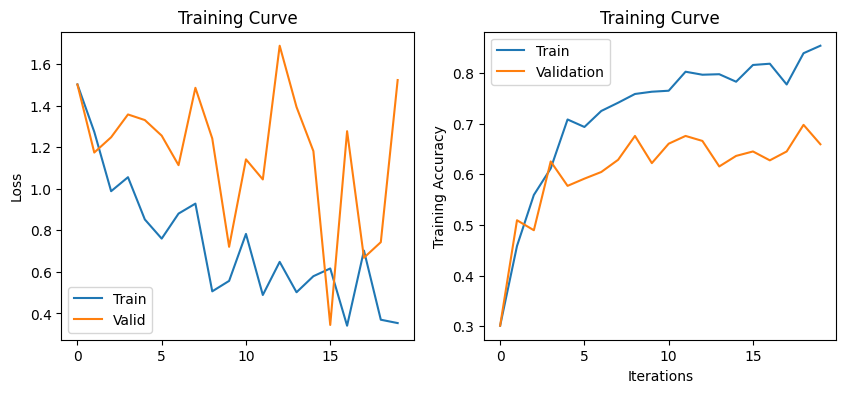

Final Training Accuracy: 0.8538993089832182
Final Validation Accuracy: 0.6593647316538883


In [139]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

In [106]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.0001)

Epoch: 0, loss train: 1.61, loss valid: 1.5999842882156372
Accuracy train: 0.09081934846989141
Accuracy valid: 0.09419496166484119
Epoch: 1, loss train: 1.56, loss valid: 1.5440617799758911
Accuracy train: 0.1895360315893386
Accuracy valid: 0.22343921139101863
Epoch: 2, loss train: 1.53, loss valid: 1.478910207748413
Accuracy train: 0.5212240868706811
Accuracy valid: 0.5224534501642936
Epoch: 3, loss train: 1.48, loss valid: 1.4822072982788086
Accuracy train: 0.5429417571569596
Accuracy valid: 0.547645125958379
Epoch: 4, loss train: 1.46, loss valid: 1.3822956085205078
Accuracy train: 0.5468904244817374
Accuracy valid: 0.5531215772179627
Epoch: 5, loss train: 1.44, loss valid: 1.48439359664917
Accuracy train: 0.5463968410661402
Accuracy valid: 0.5553121577217963
Epoch: 6, loss train: 1.45, loss valid: 1.4844703674316406
Accuracy train: 0.5493583415597236
Accuracy valid: 0.5553121577217963
Epoch: 7, loss train: 1.31, loss valid: 1.4276914596557617
Accuracy train: 0.5513326752221125
Accu

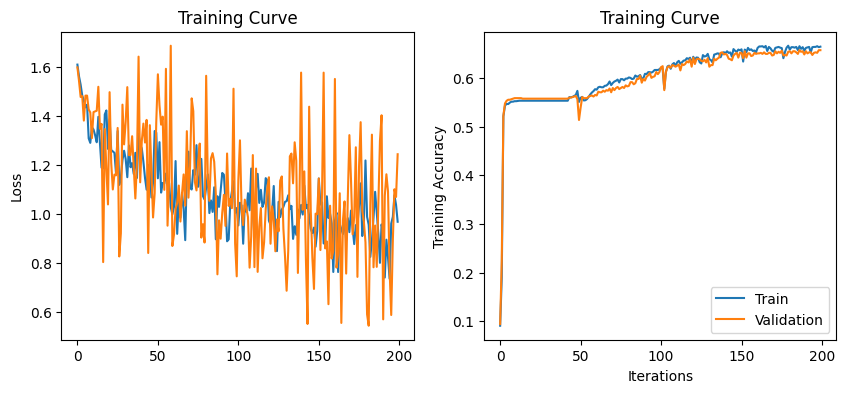

Final Training Accuracy: 0.6643632773938796
Final Validation Accuracy: 0.6571741511500547


In [108]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

In [115]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 1.79, loss valid: 1.7044988870620728
Accuracy train: 0.5513326752221125
Accuracy valid: 0.556407447973713
Epoch: 1, loss train: 1.43, loss valid: 1.7653684616088867
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5585980284775466
Epoch: 2, loss train: 1.26, loss valid: 1.3409425020217896
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 3, loss train: 1.29, loss valid: 1.0173066854476929
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 4, loss train: 1.21, loss valid: 1.0177935361862183
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 5, loss train: 1.28, loss valid: 1.1148194074630737
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 6, loss train: 1.17, loss valid: 1.4754726886749268
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 7, loss train: 1.13, loss valid: 1.090926170349121
Accuracy train: 0.5656465942744324
Accur

KeyboardInterrupt: 

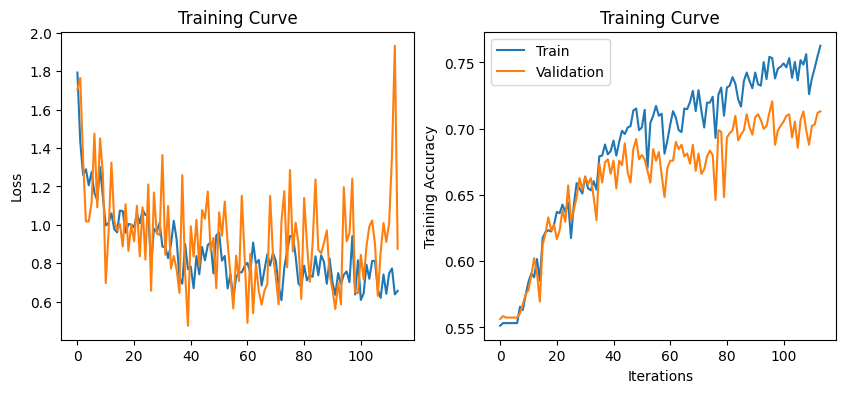

Final Training Accuracy: 0.7625863770977295
Final Validation Accuracy: 0.7130339539978094


In [116]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Model (do poprawy)

In [ ]:
num_of_columns_without_classes = 50

class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size*num_of_columns_without_classes*self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden

model = LSTMRegressor(1,5,2,1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5, num_layers=2, dropout=0.4)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        print(f"AAA: {type(targets)}")
        x = x.to(device).unsqueeze(2)
#         x = x.unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

ValueError: too many values to unpack (expected 2)

In [ ]:
# with torch.no_grad():
#     hidden, state = model.init_hidden(len(test_data))
#     hidden, state = hidden.to(device), state.to(device)
#     preds,_ =  model(test_data.to(device).unsqueeze(2), (hidden,state))
# print(f"Accuracy: {(torch.argmax(preds,1).cpu()==test_targets).sum().item()/len(test_targets):.3}")